In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import h5py
import pandas as pd
import numpy as np
import tensorflow as tf
import os
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt
import gc
from keras.utils import to_categorical


In [3]:
def find_fmri_data_folder(start_path):
    for root, dirs, files in os.walk(start_path):
        if 'meg_data' in dirs:
            return os.path.join(root, 'meg_data/Intra/train')
    raise Exception("meg_data folder not found. Please check the directory structure.")

def get_dataset_name(file_name_with_dir):
    filename_without_dir = file_name_with_dir.split('/')[-1]
    temp = filename_without_dir.split('_')[:-1]
    dataset_name = "_".join(temp)
    return dataset_name

def assign_label(file_name):
    if file_name.startswith("rest"):
        return 0
    elif file_name.startswith("task_motor"):
        return 1
    elif file_name.startswith("task_story"):
        return 2
    elif file_name.startswith("task_working"):
        return 3
    else:
        return None

def load_data(file_path):
    with h5py.File(file_path, 'r') as f:
        dataset_name = get_dataset_name(file_path)
        matrix = f.get(dataset_name)[:]
        return matrix

fmri_data_folder = find_fmri_data_folder('/content/drive/My Drive')
meg_data_list = []
labels = []

for file in os.listdir(fmri_data_folder):
    if file.endswith('.h5'):
        file_path = os.path.join(fmri_data_folder, file)
        data = load_data(file_path)
        meg_data_list.append(data)
        labels.append(assign_label(file))

        # Clear memory
        del data
        gc.collect()

# Convert the list of 2D arrays into a single 3D NumPy array
meg_train_data_array = np.stack(meg_data_list, axis=0)
labels_train_array = np.array(labels)

In [4]:
def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyq = 0.5 * fs  # Nyquist Frequency
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

def apply_lowpass(array):
  original_sampling_rate = 2034  # Original sampling rate
  downsampling_factor = 4
  new_sampling_rate = original_sampling_rate / downsampling_factor  # New sampling rate after downsampling
  cutoff_frequency = new_sampling_rate / 2  # Nyquist frequency

  array_filtered = np.zeros_like(array)

  for o in range(array.shape[0]):
      for i in range(array.shape[1]):
          array_filtered[o, i, :] = butter_lowpass_filter(array[o, i, :], cutoff_frequency, original_sampling_rate)
  del array
  gc.collect()
  return array_filtered


def apply_downsampling(array):
  n_observations, n_sensors, n_timepoints = array.shape
  downsampling_factor = 4
  new_n_timepoints = n_timepoints // downsampling_factor
  array_downsamp = np.zeros((n_observations, n_sensors, new_n_timepoints))

  for obs in range(n_observations):
    for sensor in range(n_sensors):
      array_downsamp[obs,sensor,:] = array[obs, sensor, ::downsampling_factor]

  del array, new_n_timepoints, downsampling_factor, n_observations, n_sensors, n_timepoints
  gc.collect()
  return array_downsamp



In [5]:
# per file
def min_max_scaling_per_file(data):
    # Initialize an empty array with the same shape as the input data
    scaled_data = np.zeros_like(data)

    # Iterate over each file
    for file_index in range(data.shape[0]):
        file_data = data[file_index, :, :]

        # Compute the min and max for this file
        min_val = np.min(file_data)
        max_val = np.max(file_data)

        # Apply Min-Max scaling for this file
        scaled_data[file_index, :, :] = (file_data - min_val) / (max_val - min_val) if max_val != min_val else file_data

    return scaled_data

# per sensor
def min_max_scaling_per_sensor(data):
    # Initialize an empty array with the same shape as the input data
    scaled_data = np.zeros_like(data)

    # Iterate over each sensor
    for sensor in range(data.shape[1]):
        # Flatten the data for this sensor across all files and timepoints
        sensor_data = data[:, sensor, :].flatten()

        # Compute the min and max for this sensor
        min_val = np.min(sensor_data)
        max_val = np.max(sensor_data)

        # Apply Min-Max scaling for this sensor
        scaled_data[:, sensor, :] = (data[:, sensor, :] - min_val) / (max_val - min_val)

    return scaled_data



(8, 248, 8906)
(8, 248, 8906)
(8, 248, 8906)
(8, 248, 8906)


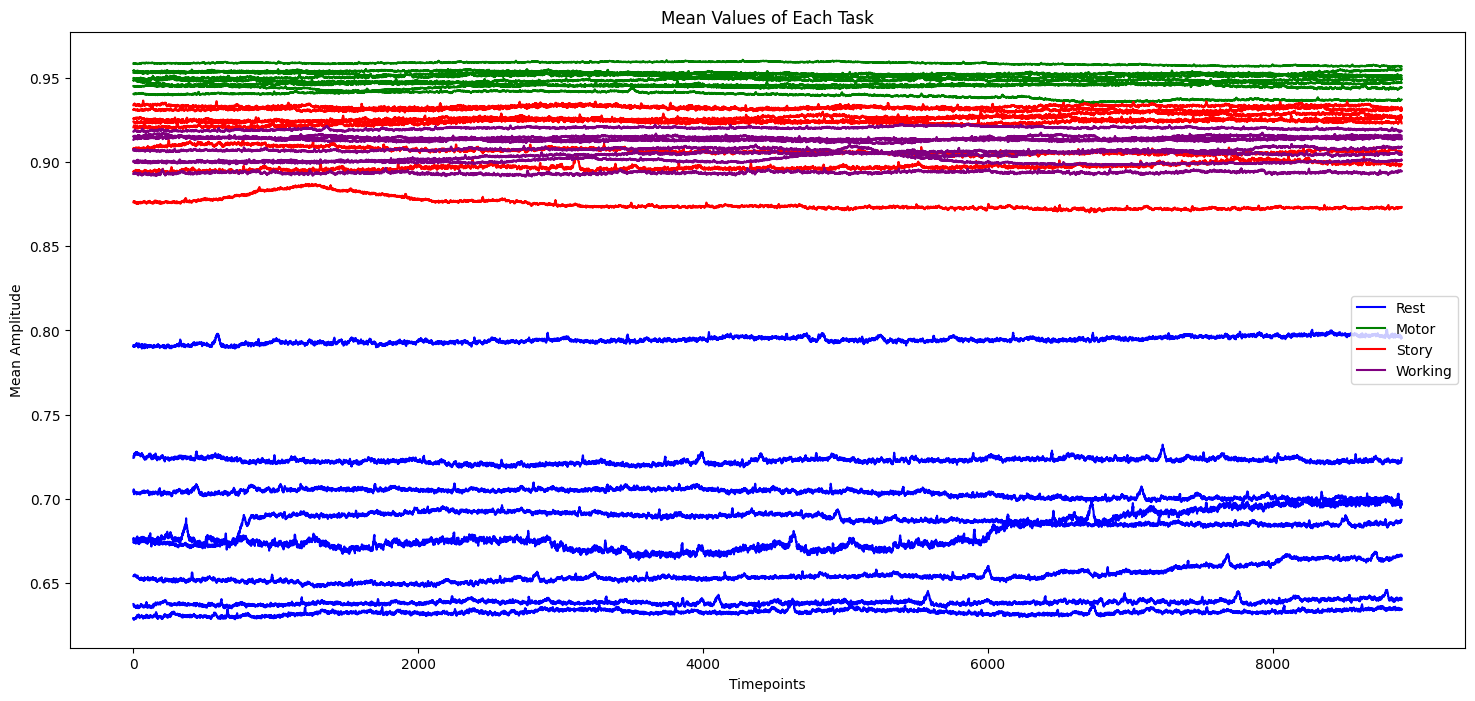

In [6]:
#############################################################################
############################## MIN-MAX SCALING ##############################
#############################################################################

# APPLY SCALING FILTER AND DOWNSAMPLING
array_scaled_min_max = min_max_scaling_per_file(meg_train_data_array)
array_filtered = apply_lowpass(array_scaled_min_max)
del array_scaled_min_max
array_doensampled = apply_downsampling(array_filtered)
del array_filtered

# SEPARATE EACH MOTOR TASK IN DIFFERENT ARRAY

rest_class = array_doensampled[labels_train_array == 0]
motor_class = array_doensampled[labels_train_array == 1]
story_class = array_doensampled[labels_train_array == 2]
working_class = array_doensampled[labels_train_array == 3]

rest_labels = labels_train_array[labels_train_array==0]
motor_labels = labels_train_array[labels_train_array==1]
story_labels = labels_train_array[labels_train_array==2]
working_labels = labels_train_array[labels_train_array==3]


print(rest_class.shape)
print(motor_class.shape)
print(story_class.shape)
print(working_class.shape)



# AVERAGE ALL SENSORSOF EACH OBSERVATION

mean_rest_class = np.mean(rest_class, axis=1)
mean_motor_class = np.mean(motor_class, axis=1)
mean_story_class = np.mean(story_class, axis=1)
mean_working_class = np.mean(working_class, axis=1)

del rest_class, motor_class, story_class, working_class


def plot_task_means(mean_arrays, task_labels, colors):
    plt.figure(figsize=(18, 8))

    # Plot an empty line for each task to create the legend
    for label, color in zip(task_labels, colors):
        plt.plot([], [], label=label, color=color)

    # Plot the actual data
    for mean_array, color in zip(mean_arrays, colors):
        for line in mean_array:
            plt.plot(line, color=color, alpha=1)

    plt.title("Mean Values of Each Task")
    plt.xlabel("Timepoints")
    plt.ylabel("Mean Amplitude")
    plt.legend()
    plt.show()

# Example usage remains the same
mean_arrays = [mean_rest_class, mean_motor_class, mean_story_class, mean_working_class]
task_labels = ["Rest", "Motor", "Story", "Working"]
colors = ["blue", "green", "red", "purple"]

plot_task_means(mean_arrays, task_labels, colors)


del mean_arrays, task_labels, colors

In [7]:
print(mean_rest_class.shape, mean_motor_class.shape, mean_story_class.shape, mean_working_class.shape)

obs, timepoints = mean_rest_class.shape

mean_rest_class = mean_rest_class.reshape(obs,timepoints,1)
mean_motor_class = mean_motor_class.reshape(obs,timepoints,1)
mean_story_class = mean_story_class.reshape(obs,timepoints,1)
mean_working_class = mean_working_class.reshape(obs,timepoints,1)

rest_labels = rest_labels.reshape(-1,1)
motor_labels = motor_labels.reshape(-1,1)
story_labels = story_labels.reshape(-1,1)
working_labels = working_labels.reshape(-1,1)

print(mean_rest_class.shape, mean_motor_class.shape, mean_story_class.shape, mean_working_class.shape)
print(rest_labels.shape, motor_labels.shape, story_labels.shape, working_labels.shape)

(8, 8906) (8, 8906) (8, 8906) (8, 8906)
(8, 8906, 1) (8, 8906, 1) (8, 8906, 1) (8, 8906, 1)
(8, 1) (8, 1) (8, 1) (8, 1)


In [8]:
X_train = np.stack((mean_rest_class, mean_motor_class, mean_story_class, mean_working_class))
y_train = np.stack((rest_labels, motor_labels, story_labels, working_labels))

obs, inst, timepoints, _ = X_train.shape
X_train = X_train.reshape(obs*inst,timepoints,1)
y_train = y_train.reshape(obs*inst,1)

X_train = X_train.reshape(X_train.shape[0], -1)
y_train_flat = y_train.ravel()

# y_train = to_categorical(y_train, num_classes=4)

print(X_train.shape, y_train_flat.shape)

(32, 8906) (32,)


In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from scipy.stats import uniform

In [10]:
pipeline = Pipeline([
    ('svm', SVC())                 # Apply SVM
])

param_dist = {
    'svm__C': uniform(loc=0.001, scale=100),
    'svm__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'svm__degree': [2, 3, 4],
    'svm__gamma': ['scale', 'auto'] + list(np.logspace(-3, 3, 7))
}



random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)


In [11]:
random_search.fit(X_train, y_train)


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=5, estimator=Pipeline(steps=[('svm', SVC())]), n_jobs=-1,
                   param_distributions={'svm__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7ebab4135030>,
                                        'svm__degree': [2, 3, 4],
                                        'svm__gamma': ['scale', 'auto', 0.001,
                                                       0.01, 0.1, 1.0, 10.0,
                                                       100.0, 1000.0],
                                        'svm__kernel': ['linear', 'poly', 'rbf',
                                                        'sigmoid']},
                   random_state=42, scoring='accuracy')

In [12]:
print(np.unique(y_train_flat))


[0 1 2 3]


In [13]:
################ TEST DATA ####################

# Retrieve Test data

def find_fmri_data_folder(start_path):
    for root, dirs, files in os.walk(start_path):
        if 'meg_data' in dirs:
            return os.path.join(root, 'meg_data/Intra/test')
    raise Exception("meg_data folder not found. Please check the directory structure.")

def get_dataset_name(file_name_with_dir):
    filename_without_dir = file_name_with_dir.split('/')[-1]
    temp = filename_without_dir.split('_')[:-1]
    dataset_name = "_".join(temp)
    return dataset_name

def assign_label(file_name):
    if file_name.startswith("rest"):
        return 0
    elif file_name.startswith("task_motor"):
        return 1
    elif file_name.startswith("task_story"):
        return 2
    elif file_name.startswith("task_working"):
        return 3
    else:
        return None

def load_data(file_path):
    with h5py.File(file_path, 'r') as f:
        dataset_name = get_dataset_name(file_path)
        matrix = f.get(dataset_name)[:]
        return matrix

fmri_data_folder = find_fmri_data_folder('/content/drive/My Drive')
meg_test_data_list = []
labels_test = []

for file in os.listdir(fmri_data_folder):
    if file.endswith('.h5'):
        file_path = os.path.join(fmri_data_folder, file)
        data = load_data(file_path)
        meg_test_data_list.append(data)
        labels_test.append(assign_label(file))

        # Clear memory
        del data
        gc.collect()

# Convert the list of 2D arrays into a single 3D NumPy array
meg_test_data_array = np.stack(meg_test_data_list, axis=0)
labels_test_array = np.array(labels_test)



In [14]:
meg_test_data_array.shape

(8, 248, 35624)

In [15]:
labels_test_array

array([1, 3, 2, 2, 1, 0, 3, 0])

(2, 248, 8906)
(2, 248, 8906)
(2, 248, 8906)
(2, 248, 8906)


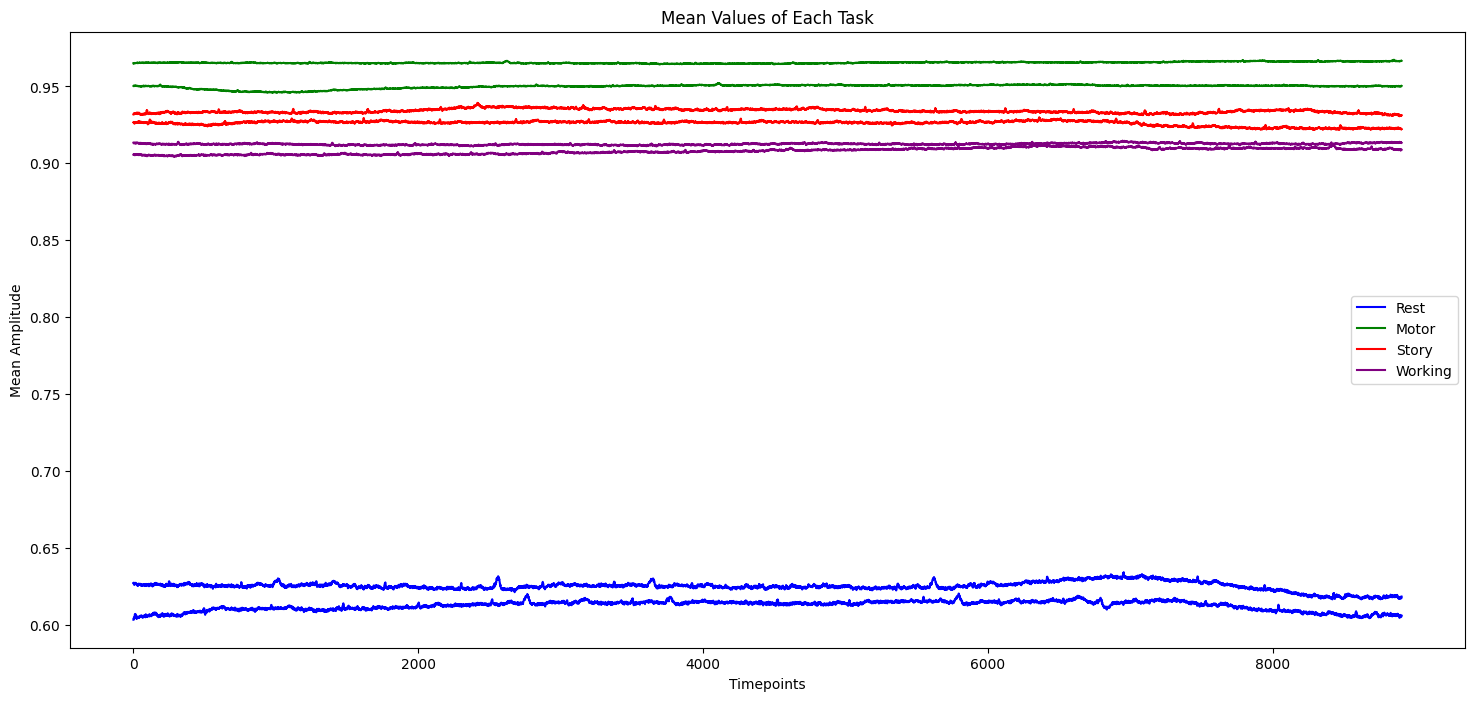

In [16]:
#############################################################################
############################## MIN-MAX SCALING ##############################
#############################################################################

# APPLY SCALING FILTER AND DOWNSAMPLING
array_scaled_min_max = min_max_scaling_per_file(meg_test_data_array)
array_filtered = apply_lowpass(array_scaled_min_max)
del array_scaled_min_max
array_doensampled = apply_downsampling(array_filtered)
del array_filtered

# SEPARATE EACH MOTOR TASK IN DIFFERENT ARRAY

rest_class = array_doensampled[labels_test_array == 0]
motor_class = array_doensampled[labels_test_array == 1]
story_class = array_doensampled[labels_test_array == 2]
working_class = array_doensampled[labels_test_array == 3]

rest_labels = labels_test_array[labels_test_array==0]
motor_labels = labels_test_array[labels_test_array==1]
story_labels = labels_test_array[labels_test_array==2]
working_labels = labels_test_array[labels_test_array==3]


print(rest_class.shape)
print(motor_class.shape)
print(story_class.shape)
print(working_class.shape)



# AVERAGE ALL SENSORSOF EACH OBSERVATION

mean_rest_class = np.mean(rest_class, axis=1)
mean_motor_class = np.mean(motor_class, axis=1)
mean_story_class = np.mean(story_class, axis=1)
mean_working_class = np.mean(working_class, axis=1)

del rest_class, motor_class, story_class, working_class


def plot_task_means(mean_arrays, task_labels, colors):
    plt.figure(figsize=(18, 8))

    # Plot an empty line for each task to create the legend
    for label, color in zip(task_labels, colors):
        plt.plot([], [], label=label, color=color)

    # Plot the actual data
    for mean_array, color in zip(mean_arrays, colors):
        for line in mean_array:
            plt.plot(line, color=color, alpha=1)

    plt.title("Mean Values of Each Task")
    plt.xlabel("Timepoints")
    plt.ylabel("Mean Amplitude")
    plt.legend()
    plt.show()

# Example usage remains the same
mean_arrays = [mean_rest_class, mean_motor_class, mean_story_class, mean_working_class]
task_labels = ["Rest", "Motor", "Story", "Working"]
colors = ["blue", "green", "red", "purple"]

plot_task_means(mean_arrays, task_labels, colors)


del mean_arrays, task_labels, colors

In [17]:
print(mean_rest_class.shape, mean_motor_class.shape, mean_story_class.shape, mean_working_class.shape)

obs, timepoints = mean_rest_class.shape

mean_rest_class = mean_rest_class.reshape(obs,timepoints,1)
mean_motor_class = mean_motor_class.reshape(obs,timepoints,1)
mean_story_class = mean_story_class.reshape(obs,timepoints,1)
mean_working_class = mean_working_class.reshape(obs,timepoints,1)

rest_labels = rest_labels.reshape(-1,1)
motor_labels = motor_labels.reshape(-1,1)
story_labels = story_labels.reshape(-1,1)
working_labels = working_labels.reshape(-1,1)

print(mean_rest_class.shape, mean_motor_class.shape, mean_story_class.shape, mean_working_class.shape)
print(rest_labels.shape, motor_labels.shape, story_labels.shape, working_labels.shape)

(2, 8906) (2, 8906) (2, 8906) (2, 8906)
(2, 8906, 1) (2, 8906, 1) (2, 8906, 1) (2, 8906, 1)
(2, 1) (2, 1) (2, 1) (2, 1)


In [18]:
X_test = np.stack((mean_rest_class, mean_motor_class, mean_story_class, mean_working_class))
y_test = np.stack((rest_labels, motor_labels, story_labels, working_labels))

obs, inst, timepoints, _ = X_test.shape
X_test = X_test.reshape(obs*inst,timepoints,1)
y_test = y_test.reshape(obs*inst,1)

X_test = X_test.reshape(X_test.shape[0], -1)
y_test_flat = y_test.ravel()

# y_train = to_categorical(y_train, num_classes=4)

print(X_test.shape, y_test_flat.shape)

(8, 8906) (8,)


In [19]:
# Extract best parameters and remove the 'svm__' prefix
best_params_stripped = {key.replace('svm__', ''): value for key, value in random_search.best_params_.items()}
print(best_params_stripped)
# Create a new pipeline with the best parameters

best_svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(**best_params_stripped))
])

# Fit the pipeline on the training data
print(str(len(X_train))+":"+str(len(y_train.ravel())))
best_svm_pipeline.fit(X_train, y_train.ravel())

# Obtain predictions using the pipeline to ensure consistent scaling
predicted_labels_svm_grid = best_svm_pipeline.predict(X_test)

{'C': 70.80825777960456, 'degree': 3, 'gamma': 0.1, 'kernel': 'poly'}
32:32


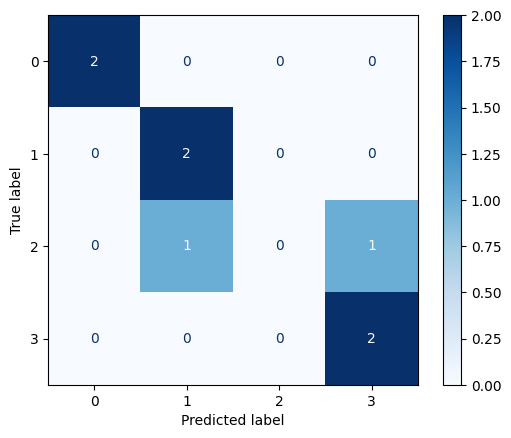

Accuracy with Random search for Best Hyper-parameters: 0.75


In [20]:
# ------------------------------RandomSearch----------------------------
# Comfusion Matrix
cm_svm_grid = confusion_matrix(y_test, predicted_labels_svm_grid)
disp_svm_grid = ConfusionMatrixDisplay(confusion_matrix=cm_svm_grid, display_labels=best_svm_pipeline.classes_)
disp_svm_grid.plot(cmap='Blues')
plt.show()

# SVM Accuracy
accuracy_svm_grid = accuracy_score(y_test, predicted_labels_svm_grid)
print("Accuracy with Random search for Best Hyper-parameters:", accuracy_svm_grid)
